In [1]:
import pandas as pd
import numpy as np
import os
import yfinance as yf
import itertools
import warnings
import functions as func
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import shapiro
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import seaborn as sns

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ValueWarning)


In [2]:
DATA_PATH = "avgo_data.json"

if os.path.exists(DATA_PATH):
    
    with open(DATA_PATH) as f:
        avgo_hist = pd.read_json(DATA_PATH)
else:
    avgo = yf.Ticker("AVGO")
    avgo_hist = avgo.history(period="max")

    avgo_hist.to_json(DATA_PATH)

In [3]:
avgo_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2009-08-06 04:00:00,11.835759,12.129860,11.161480,11.606217,24197800,0.0,0
2009-08-07 04:00:00,11.584700,12.022265,11.498623,11.785550,2454300,0.0,0
2009-08-10 04:00:00,11.929010,11.929010,11.197346,11.455581,2421000,0.0,0
2009-08-11 04:00:00,11.462755,11.477102,11.118443,11.240387,2305400,0.0,0
2009-08-12 04:00:00,11.584701,11.620568,11.233215,11.477103,1451300,0.0,0
...,...,...,...,...,...,...,...
2024-04-09 04:00:00,1357.369995,1359.479980,1308.640015,1334.079956,1800800,0.0,0
2024-04-10 04:00:00,1323.000000,1335.750000,1315.479980,1322.369995,1746700,0.0,0
2024-04-11 04:00:00,1332.680054,1391.869995,1323.650024,1382.459961,3171300,0.0,0
2024-04-12 04:00:00,1352.010010,1366.510010,1336.619995,1344.069946,2778000,0.0,0


<Axes: >

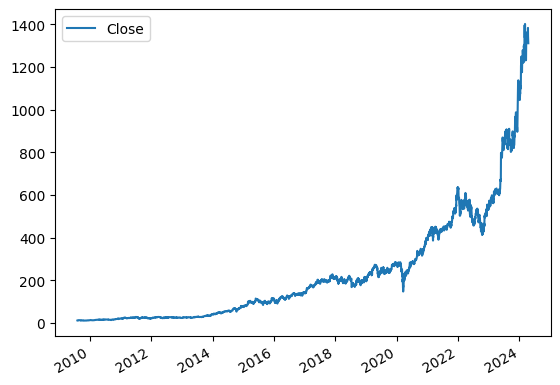

In [4]:
avgo_hist.plot.line(y="Close", use_index=True)

In [5]:
df_avgo = func.calculate_technical_indicators(avgo_hist)

In [6]:
df_avgo_clean = df_avgo.dropna(subset=['rsi'])
df_avgo_clean = df_avgo_clean.drop(columns=['Dividends', 'Stock Splits'])
df_avgo_clean.index = pd.to_datetime(df_avgo_clean.index)
start_date = pd.Timestamp('2020-01-22 05:00:00')
df_avgo_clean = df_avgo_clean[df_avgo_clean.index >= start_date]
df_avgo_clean

,Open,High,Low,Close,Volume,ema_12,ema_26,macd_line,macd_signal,rsi
2020-01-22 05:00:00,272.275237,278.512710,272.012434,274.176270,2926400,270.766385,271.968924,-1.202539,-1.043236,47.217775
2020-01-23 05:00:00,276.112270,280.159600,272.292721,280.028198,3026600,272.191280,272.565908,-0.374628,-0.909514,47.514462
2020-01-24 05:00:00,289.533321,290.479439,281.009380,283.839020,5578200,273.983240,273.400953,0.582286,-0.611154,59.566958
2020-01-27 05:00:00,277.189805,280.229686,270.382935,270.724579,3884300,273.481907,273.202703,0.279204,-0.433083,46.434511
2020-01-28 05:00:00,274.666839,279.660314,274.001035,278.854340,2316600,274.308435,273.621343,0.687092,-0.209048,53.832634
...,...,...,...,...,...,...,...,...,...,...
2024-04-09 04:00:00,1357.369995,1359.479980,1308.640015,1334.079956,1800800,1330.019876,1313.346195,16.673681,17.601892,67.119480
2024-04-10 04:00:00,1323.000000,1335.750000,1315.479980,1322.369995,1746700,1328.842971,1314.014625,14.828347,17.047183,58.769241
2024-04-11 04:00:00,1332.680054,1391.869995,1323.650024,1382.459961,3171300,1337.091739,1319.084649,18.007090,17.239164,56.824296
2024-04-12 04:00:00,1352.010010,1366.510010,1336.619995,1344.069946,2778000,1338.165309,1320.935412,17.229897,17.237311,48.353184


<Axes: >

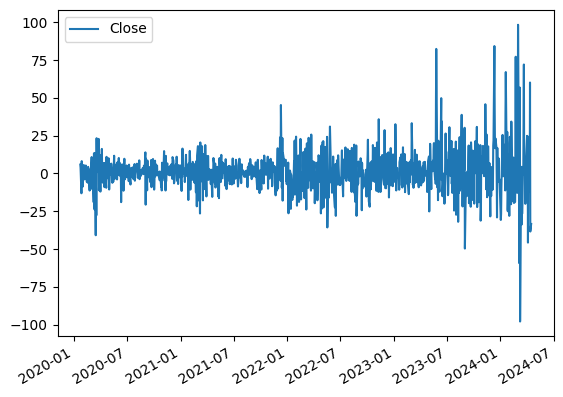

In [7]:
df_close = df_avgo_clean[['Close']].copy()
df_close.index = pd.to_datetime(df_close.index)
start_date = pd.Timestamp('2020-01-22 05:00:00')
df_close = df_close[df_close.index >= start_date]

df_diff = df_close.diff()
df_diff.plot()

## Checking for stationarity

In [8]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

stat_test = check_stationarity(df_avgo_clean['Close'])

The series is NOT stationary


In [9]:
df_diff = df_diff.drop(df_diff.index[0])
nan_count = df_diff.isna().sum().sum()
inf_count = np.isinf(df_diff).sum().sum()

print("Number of NaN values in the DataFrame:", nan_count)
print("Number of infinite values in the DataFrame:", inf_count)

Number of NaN values in the DataFrame: 0
Number of infinite values in the DataFrame: 0


In [10]:
def perform_adf_test(ts):
    adf_result = adfuller(ts)
    return adf_result

adf_result = perform_adf_test(df_diff)
print("ADF test statistics:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical values:", adf_result[4])

ADF test statistics: -7.256807642858116
p-value: 1.7223208064032537e-10
Critical values: {'1%': -3.43662916802936, '5%': -2.864312406409634, '10%': -2.5682461404339336}


The set seems to be stationary now, however a seccond diff might be needed. We will see this during the acf and pacf plotting.

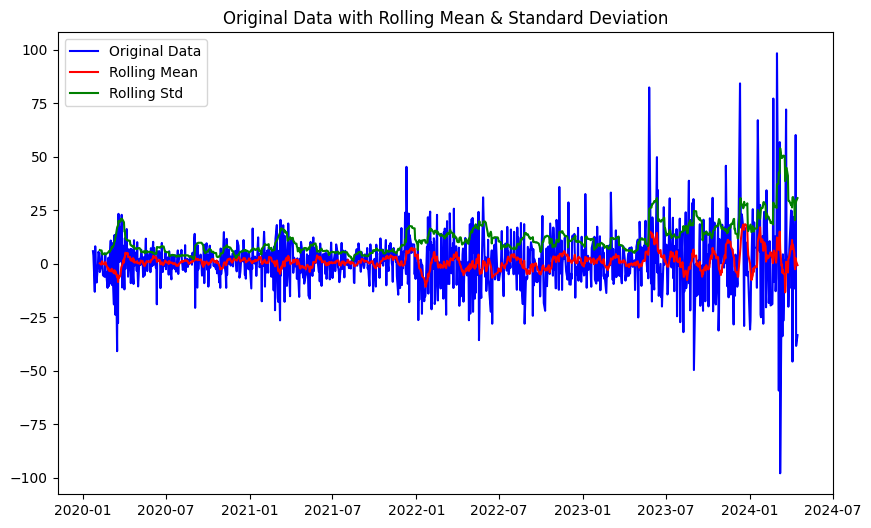

In [11]:
ts = df_diff

plt.figure(figsize=(10, 6))
plt.plot(ts, color='blue', label='Original Data')

rolling_mean = ts.rolling(window=12).mean()
rolling_std = ts.rolling(window=12).std()

plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='green', label='Rolling Std')
plt.title('Original Data with Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

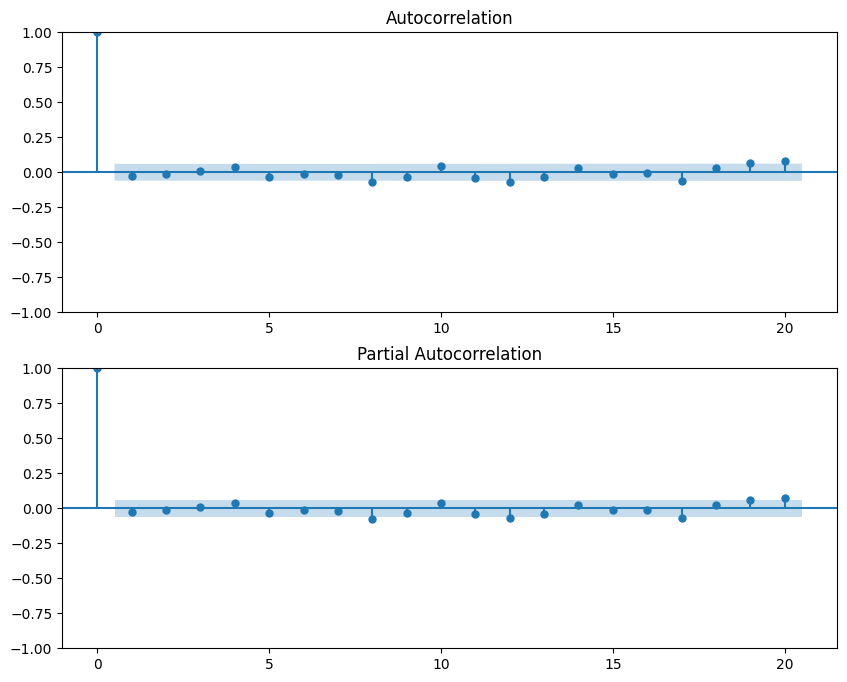

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(ts, ax=axes[0], lags=20)
plot_pacf(ts, ax=axes[1], lags=20)
plt.show()

In [13]:
df_close.index = pd.to_datetime(df_close.index)
start_date = pd.Timestamp('2020-01-22 05:00:00')
avgo_2020 = df_close[df_close.index >= start_date]

In [14]:
avgo_2020.index = pd.to_datetime(avgo_2020.index)
missing_dates = avgo_2020[avgo_2020.index.to_series().diff() != pd.Timedelta(days=1)].index
if len(missing_dates) > 0:
    print("Missing dates found in the index:", missing_dates)
else:
    print("No missing dates found in the index.")

print("Frequency of the datetime index:", avgo_2020.index.freq)

Missing dates found in the index: DatetimeIndex(['2020-01-22 05:00:00', '2020-01-27 05:00:00',
               '2020-02-03 05:00:00', '2020-02-10 05:00:00',
               '2020-02-18 05:00:00', '2020-02-24 05:00:00',
               '2020-03-02 05:00:00', '2020-03-09 04:00:00',
               '2020-03-16 04:00:00', '2020-03-23 04:00:00',
               ...
               '2024-02-12 05:00:00', '2024-02-20 05:00:00',
               '2024-02-26 05:00:00', '2024-03-04 05:00:00',
               '2024-03-11 04:00:00', '2024-03-18 04:00:00',
               '2024-03-25 04:00:00', '2024-04-01 04:00:00',
               '2024-04-08 04:00:00', '2024-04-15 04:00:00'],
              dtype='datetime64[ns]', length=227, freq=None)
Frequency of the datetime index: None


In [15]:
avgo_2020.index = pd.to_datetime(avgo_2020.index)
model = auto_arima(df_close, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8610.444, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8608.459, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8609.648, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8609.623, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8611.750, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8611.532, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.501 seconds


# ARIMA

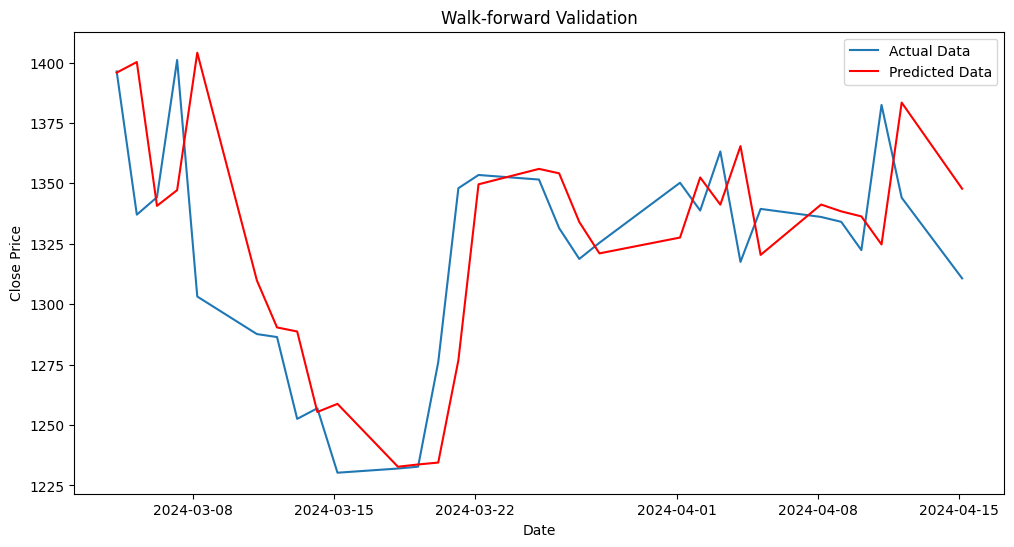

MSE:  1255.0443904604329


In [38]:
avgo_2020.index = pd.to_datetime(avgo_2020.index)

avgo_2020 = avgo_2020.sort_index()

n_test = 30

history = avgo_2020['Close'].iloc[:-n_test]
predictions = []
actual = list(avgo_2020['Close'].iloc[-n_test:])


for t in range(n_test):
    model = ARIMA(history, order=(1,2,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output.iloc[0]
    predictions.append(yhat)
    obs = actual[t]
    history = pd.concat([history, pd.Series([obs], index=[avgo_2020.index[len(history)]])])


plt.figure(figsize=(12, 6))
plt.plot(avgo_2020.index[-n_test:], actual, label='Actual Data')
plt.plot(avgo_2020.index[-n_test:], predictions, color='red', label='Predicted Data')
plt.legend()
plt.title("Walk-forward Validation")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual, predictions)
print('MSE: ', mse)

In [39]:
model = ARIMA(df_close, order=(1, 2, 1))
model_fit = model.fit()

forecast = model_fit.forecast(steps=5)
forecast_values_arima = forecast.tolist()
print("Forecasted values for the next 5 points:")
print(forecast)

Forecasted values for the next 5 points:
1065    1313.642921
1066    1315.518625
1067    1317.426271
1068    1319.332969
1069    1321.239696
Name: predicted_mean, dtype: float64


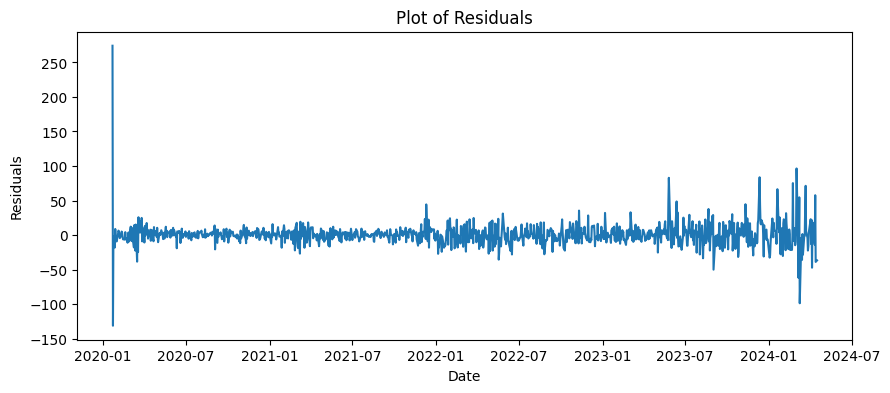

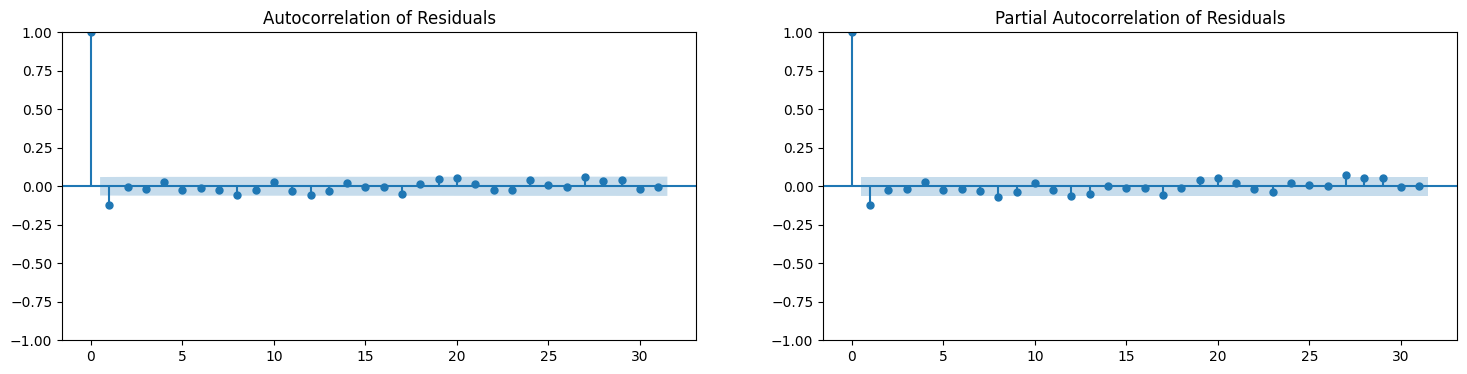

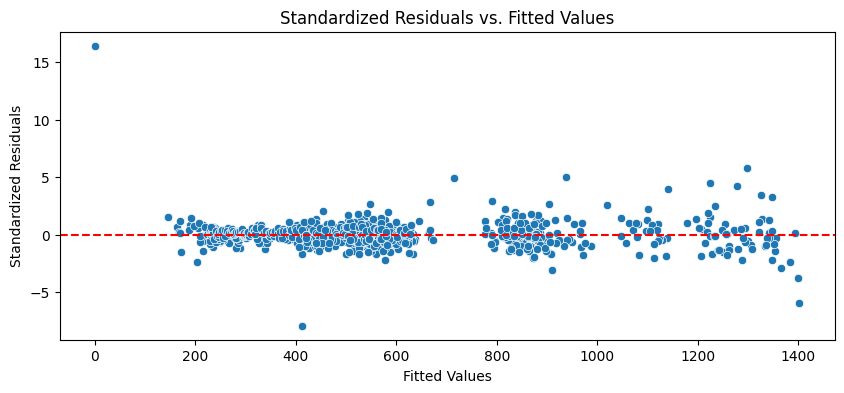

In [40]:
residuals = model_fit.resid

# Plot of residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Plot of Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# ACF and PACF of residuals
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
plot_acf(residuals, ax=ax[0], title='Autocorrelation of Residuals')
plot_pacf(residuals, ax=ax[1], title='Partial Autocorrelation of Residuals')
plt.show()

# Standardized residuals vs. fitted values
fitted_values = model_fit.fittedvalues
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

plt.figure(figsize=(10, 4))
sns.scatterplot(x=fitted_values, y=standardized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Standardized Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Standardized Residuals')
plt.show()

In [43]:
forecast_result = model_fit.get_forecast(steps=5)

mean_forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

forecast_df_arima = pd.DataFrame({
    'Forecast': mean_forecast,
    'Lower_95%': conf_int.iloc[:, 0],
    'Upper_95%': conf_int.iloc[:, 1]
})
forecast_df_arima.index = pd.date_range(start=df_avgo_clean.index[-1], periods=6, freq=df_avgo_clean.index.freq)[1:]  # Adjust indexing
forecast_df_arima

,Forecast,Lower_95%,Upper_95%
2024-04-16 04:00:00,1313.642921,1286.583525,1340.702317
2024-04-17 04:00:00,1315.518625,1277.741347,1353.295904
2024-04-18 04:00:00,1317.426271,1271.289192,1363.563349
2024-04-19 04:00:00,1319.332969,1266.083879,1372.582059
2024-04-20 04:00:00,1321.239696,1261.677222,1380.802169


C:\Users\gijsv\AppData\Local\Temp\ipykernel_13776\1583592797.py:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)


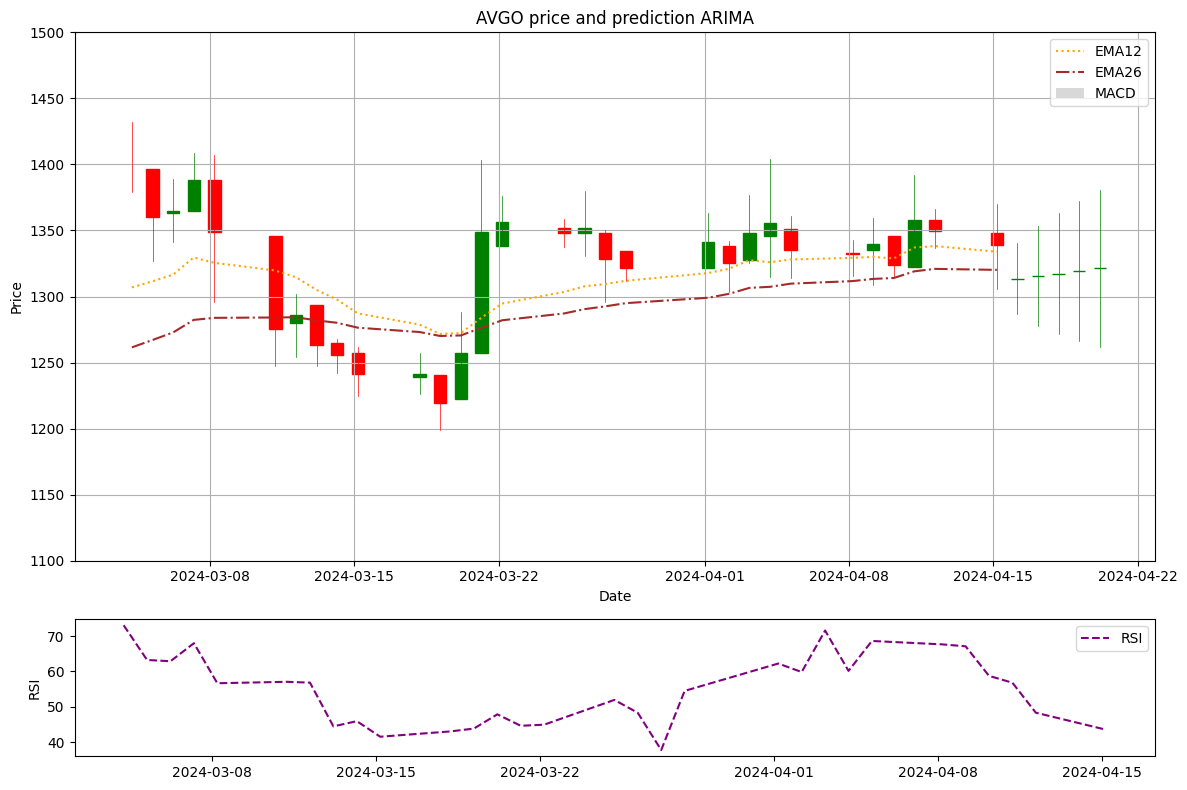

In [64]:
df_last_30 = df_avgo_clean.tail(30)
forecast_df_arima['Date'] = forecast_df_arima.index
forecast_df_arima['Date'] = forecast_df_arima['Date'].apply(mdates.date2num)

forecast_candles = pd.DataFrame({
    'Date': forecast_df_arima['Date'],
    'Open': forecast_df_arima['Forecast'],
    'High': forecast_df_arima['Upper_95%'],
    'Low': forecast_df_arima['Lower_95%'],
    'Close': forecast_df_arima['Forecast']
})

full_candles = pd.concat([df_ha, forecast_candles])

plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax1.xaxis_date()
ax1.grid(True)
ax1.set_ylim(1100, 1500) 

candlestick_ohlc(ax1, full_candles.values, width=0.6, colorup='green', colordown='red', alpha=1)

plt.plot(df_last_30.index, df_last_30['ema_12'].tail(30), label='EMA12', color='orange', linestyle='dotted')
plt.plot(df_last_30.index, df_last_30['ema_26'].tail(30), label='EMA26', color='brown', linestyle='dashdot')
plt.bar(df_last_30.index, df_last_30['macd_line'].tail(30), label='MACD', color='gray', alpha=0.3)

plt.title('AVGO price and prediction ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
ax2.bar(df_last_30.index, df_last_30['Volume'].tail(30), color='blue', alpha=0.5)
ax2.grid(True)
plt.ylabel('Volume') 

ax3 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
ax3.plot(df_last_30.index, df_last_30['rsi'].tail(30), label='RSI', color='purple', linestyle='dashed')
ax3.legend()
ax3.set_ylabel('RSI')

plt.tight_layout()
plt.show()

In [19]:
last_date = avgo_2020.index[-1]

forecast_dates_arima = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=5, freq='D')

forecast_with_dates_arima = pd.DataFrame({'Forecast': forecast_values_arima}, index=forecast_dates_arima)
print(forecast_with_dates_arima)

                        Forecast
2024-04-16 04:00:00  1314.438101
2024-04-17 04:00:00  1316.964925
2024-04-18 04:00:00  1318.861749
2024-04-19 04:00:00  1320.799717
2024-04-20 04:00:00  1322.747753


C:\Users\gijsv\AppData\Local\Temp\ipykernel_13776\1234127139.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((4, 1), (3, 0), sharex=ax1, rowspan=1)


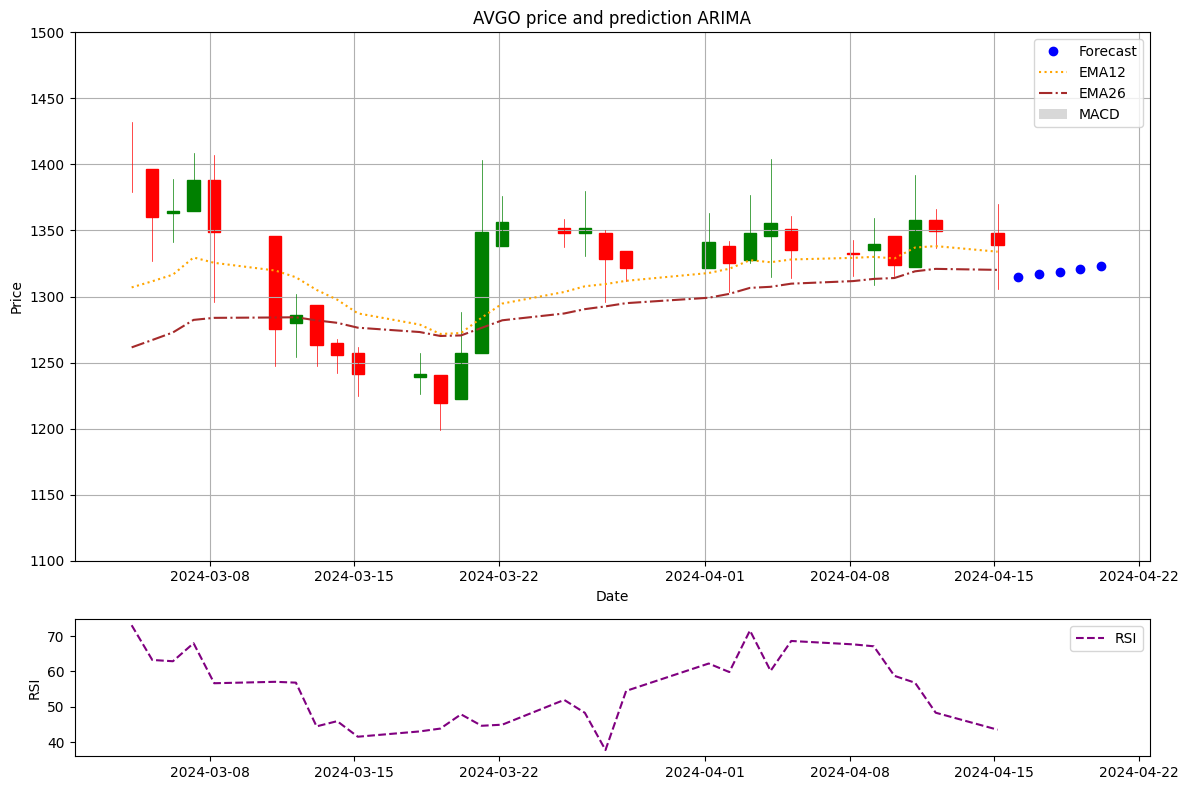

In [56]:
df_avgo_clean.index = pd.to_datetime(df_avgo_clean.index)

df_last_30 = df_avgo_clean.tail(30)

ha_close = (df_last_30['Open'] + df_last_30['High'] + df_last_30['Low'] + df_last_30['Close']) / 4
ha_open = (df_last_30['Open'].shift(1) + df_last_30['Close'].shift(1)) / 2
ha_high = df_last_30[['High', 'Open', 'Close']].max(axis=1)
ha_low = df_last_30[['Low', 'Open', 'Close']].min(axis=1)


df_ha = pd.DataFrame({'Date': df_last_30.index,
                      'Open': ha_open,
                      'High': ha_high,
                      'Low': ha_low,
                      'Close': ha_close})


plt.figure(figsize=(12, 8))


ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax1.xaxis_date()
ax1.grid(True)
ax1.set_ylim(1100, 1500)

df_ha['Date'] = df_ha['Date'].apply(mdates.date2num)

candlestick_ohlc(ax1, df_ha.values, width=0.6, colorup='green', colordown='red', alpha=1)

plt.plot(forecast_dates_arima, forecast_with_dates_arima['Forecast'], marker='o', color='blue', linestyle='None', label='Forecast')

# plt.plot(df_last_30.index, df_last_30['rsi'].tail(30), label='RSI', color='purple', linestyle='dashed')
plt.plot(df_last_30.index, df_last_30['ema_12'].tail(30), label='EMA12', color='orange', linestyle='dotted')
plt.plot(df_last_30.index, df_last_30['ema_26'].tail(30), label='EMA26', color='brown', linestyle='dashdot')
plt.bar(df_last_30.index, df_last_30['macd_line'].tail(30), label='MACD', color='gray', alpha=0.3)

plt.title('AVGO price and prediction ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

ax2 = plt.subplot2grid((4, 1), (3, 0), sharex=ax1, rowspan=1)
ax2.bar(df_last_30.index, df_last_30['Volume'].tail(30), color='blue', alpha=0.5)
ax2.grid(True)
plt.ylabel('Volume') 

ax3 = plt.subplot2grid((4, 1), (3, 0), sharex=ax1, rowspan=1)

ax3.plot(df_last_30.index, df_last_30['rsi'].tail(30), label='RSI', color='purple', linestyle='dashed')

ax3.legend()
ax3.set_ylabel('RSI')
plt.tight_layout()

plt.show()

# SARIMA 12

In [21]:
s = 12
model_sarima_12 = auto_arima(df_close, seasonal=True, m=s, max_order=None)

In [22]:
model_sarima_12

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

## Walk forward validation

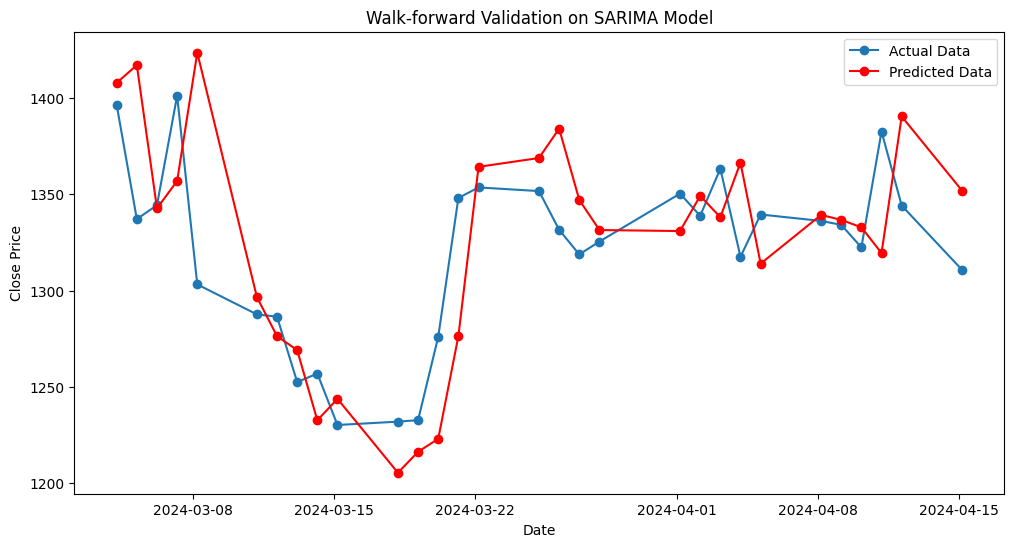

MSE: 1636.8140808504318


In [49]:
df_avgo_clean.index = pd.to_datetime(df_avgo_clean.index)
df_avgo_clean = df_avgo_clean.sort_index()

n_test = 30
train_data = df_avgo_clean['Close'].iloc[:-n_test]
test_data = df_avgo_clean['Close'].iloc[-n_test:]
dates = df_avgo_clean.index[-n_test:] 

history = train_data.copy()
predictions = []
for t in range(n_test):
    model = SARIMAX(history, order=(5, 2, 0), seasonal_order=(1, 0, 1, 12))
    model_fit = model.fit(disp=False)
    output = model_fit.forecast()
    yhat = output.iloc[0]
    predictions.append(yhat)
    obs = test_data.iloc[t]

    new_index = [dates[t]]
    history = pd.concat([history, pd.Series([obs], index=new_index)])

plt.figure(figsize=(12, 6))
plt.plot(dates, test_data, label='Actual Data', marker='o')
plt.plot(dates, predictions, color='red', label='Predicted Data', marker='o')
plt.legend()
plt.title("Walk-forward Validation on SARIMA Model")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

mse = mean_squared_error(test_data, predictions)
print('MSE:', mse)

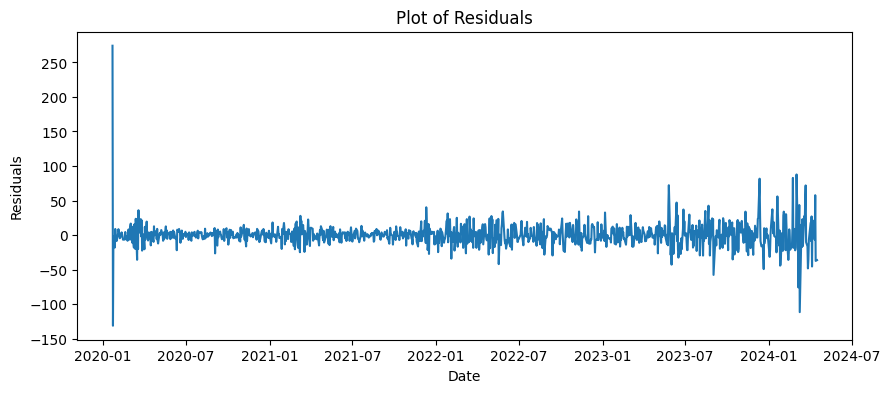

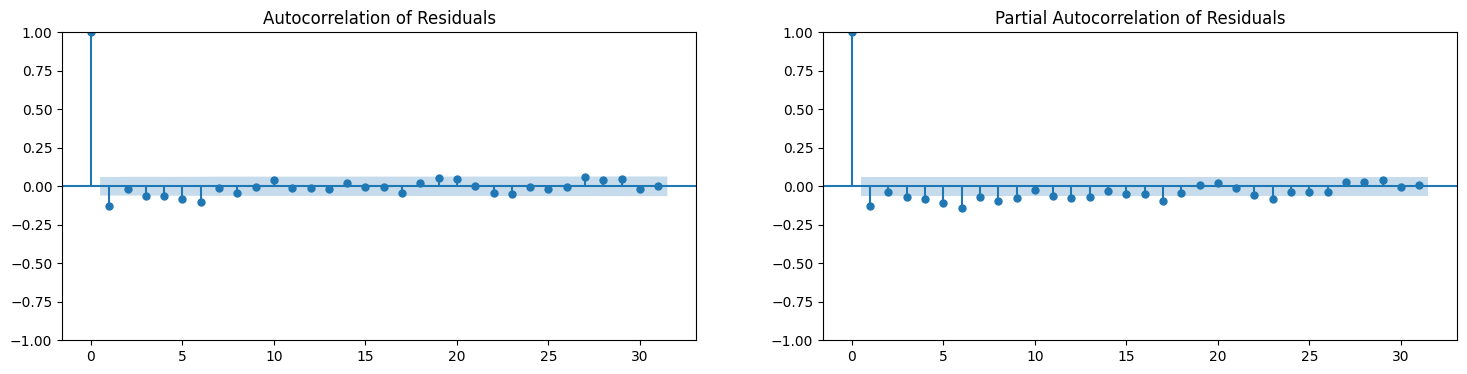

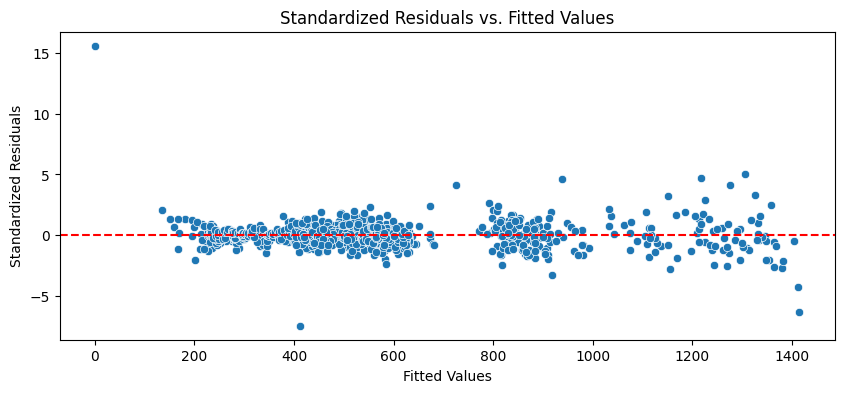

Forecasted values: [1306.2412926323836, 1303.152739060925, 1295.708518328991, 1290.4171820465021, 1280.3945848885937]


In [33]:
order = (5, 2, 0)
seasonal_order = (1, 0, 1, 12)
model_sarimax_12 = SARIMAX(df_avgo_clean['Close'], order=order, seasonal_order=seasonal_order)
model_fit_sarima_12 = model_sarimax_12.fit()

residuals = model_fit_sarima_12.resid

# Plot of residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Plot of Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# ACF and PACF of residuals
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
plot_acf(residuals, ax=ax[0], title='Autocorrelation of Residuals')
plot_pacf(residuals, ax=ax[1], title='Partial Autocorrelation of Residuals')
plt.show()

# Standardized residuals vs. fitted values
fitted_values = model_fit_sarima_12.fittedvalues
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

plt.figure(figsize=(10, 4))
sns.scatterplot(x=fitted_values, y=standardized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Standardized Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Standardized Residuals')
plt.show()

forecast_sarima_12 = model_fit_sarima_12.forecast(steps=5)
forecast_values_sarima_12 = forecast_sarima_12.tolist()
print("Forecasted values:", forecast_values_sarima_12)

In [51]:
forecast_result = model_fit_sarima_12.get_forecast(steps=5)

mean_forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

forecast_df_sarima_12 = pd.DataFrame({
    'Forecast': mean_forecast,
    'Lower_95%': conf_int.iloc[:, 0],
    'Upper_95%': conf_int.iloc[:, 1]
})
forecast_df_sarima_12.index = pd.date_range(start=df_avgo_clean.index[-1], periods=6, freq=df_avgo_clean.index.freq)[1:]  # Adjust indexing
forecast_df_sarima_12

,Forecast,Lower_95%,Upper_95%
2024-04-16 04:00:00,1306.241293,1277.054895,1335.427691
2024-04-17 04:00:00,1303.152739,1258.804946,1347.500532
2024-04-18 04:00:00,1295.708518,1236.785680,1354.631356
2024-04-19 04:00:00,1290.417182,1215.870545,1364.963819
2024-04-20 04:00:00,1280.394585,1188.107294,1372.681875


C:\Users\gijsv\AppData\Local\Temp\ipykernel_13776\1378116300.py:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)


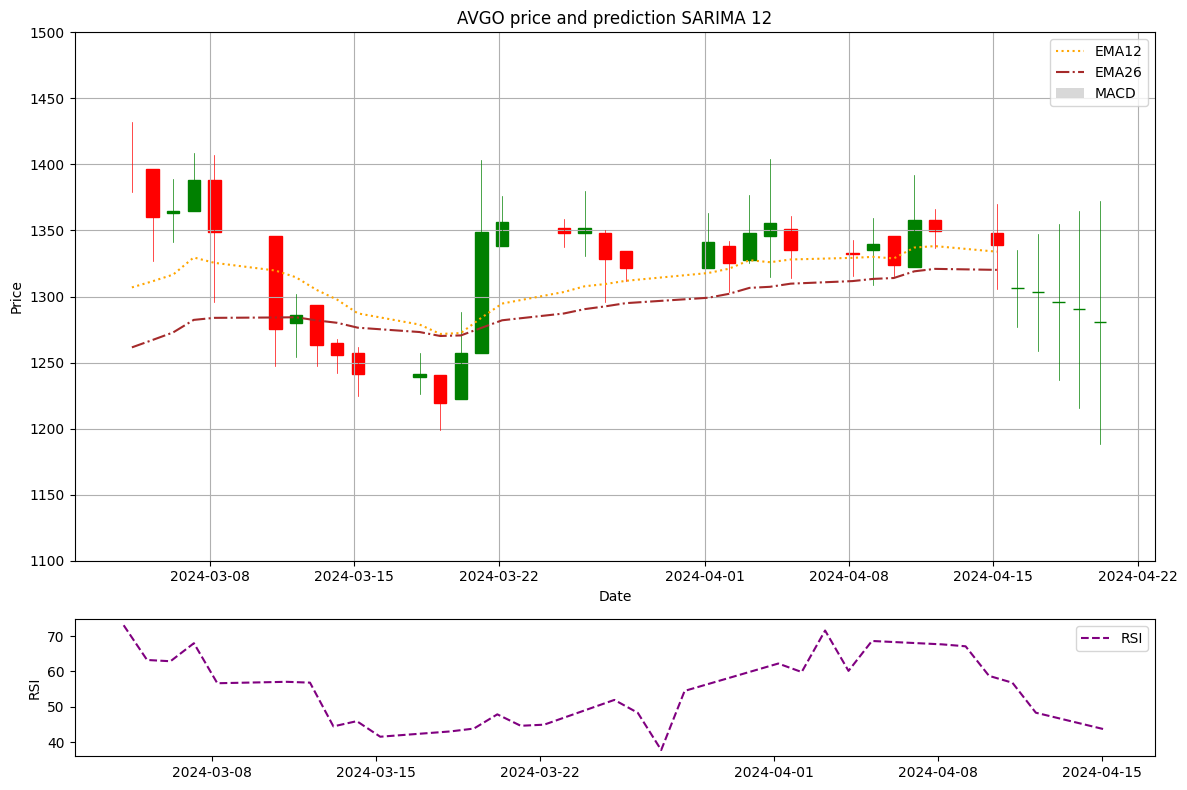

In [58]:
forecast_df_sarima_12['Date'] = forecast_df_sarima_12.index
forecast_df_sarima_12['Date'] = forecast_df_sarima_12['Date'].apply(mdates.date2num)

forecast_candles = pd.DataFrame({
    'Date': forecast_df_sarima_12['Date'],
    'Open': forecast_df_sarima_12['Forecast'],
    'High': forecast_df_sarima_12['Upper_95%'],
    'Low': forecast_df_sarima_12['Lower_95%'],
    'Close': forecast_df_sarima_12['Forecast']
})

full_candles = pd.concat([df_ha, forecast_candles])

plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax1.xaxis_date()
ax1.grid(True)
ax1.set_ylim(1100, 1500) 

candlestick_ohlc(ax1, full_candles.values, width=0.6, colorup='green', colordown='red', alpha=1)

plt.plot(df_last_30.index, df_last_30['ema_12'].tail(30), label='EMA12', color='orange', linestyle='dotted')
plt.plot(df_last_30.index, df_last_30['ema_26'].tail(30), label='EMA26', color='brown', linestyle='dashdot')
plt.bar(df_last_30.index, df_last_30['macd_line'].tail(30), label='MACD', color='gray', alpha=0.3)

plt.title('AVGO price and prediction SARIMA 12')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
ax2.bar(df_last_30.index, df_last_30['Volume'].tail(30), color='blue', alpha=0.5)
ax2.grid(True)
plt.ylabel('Volume') 

ax3 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
ax3.plot(df_last_30.index, df_last_30['rsi'].tail(30), label='RSI', color='purple', linestyle='dashed')
ax3.legend()
ax3.set_ylabel('RSI')

plt.tight_layout()
plt.show()

In [25]:
last_date = df_avgo_clean.index[-1]

forecast_dates_sarima_12 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=5, freq='D')

forecast_with_dates_sarima_12 = pd.DataFrame({'Forecast': forecast_values_sarima_12}, index=forecast_dates_sarima_12)
print(forecast_with_dates_sarima_12)

                        Forecast
2024-04-16 04:00:00  1306.241293
2024-04-17 04:00:00  1303.152739
2024-04-18 04:00:00  1295.708518
2024-04-19 04:00:00  1290.417182
2024-04-20 04:00:00  1280.394585


C:\Users\gijsv\AppData\Local\Temp\ipykernel_13776\3994554179.py:45: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((4, 1), (3, 0), sharex=ax1, rowspan=1)


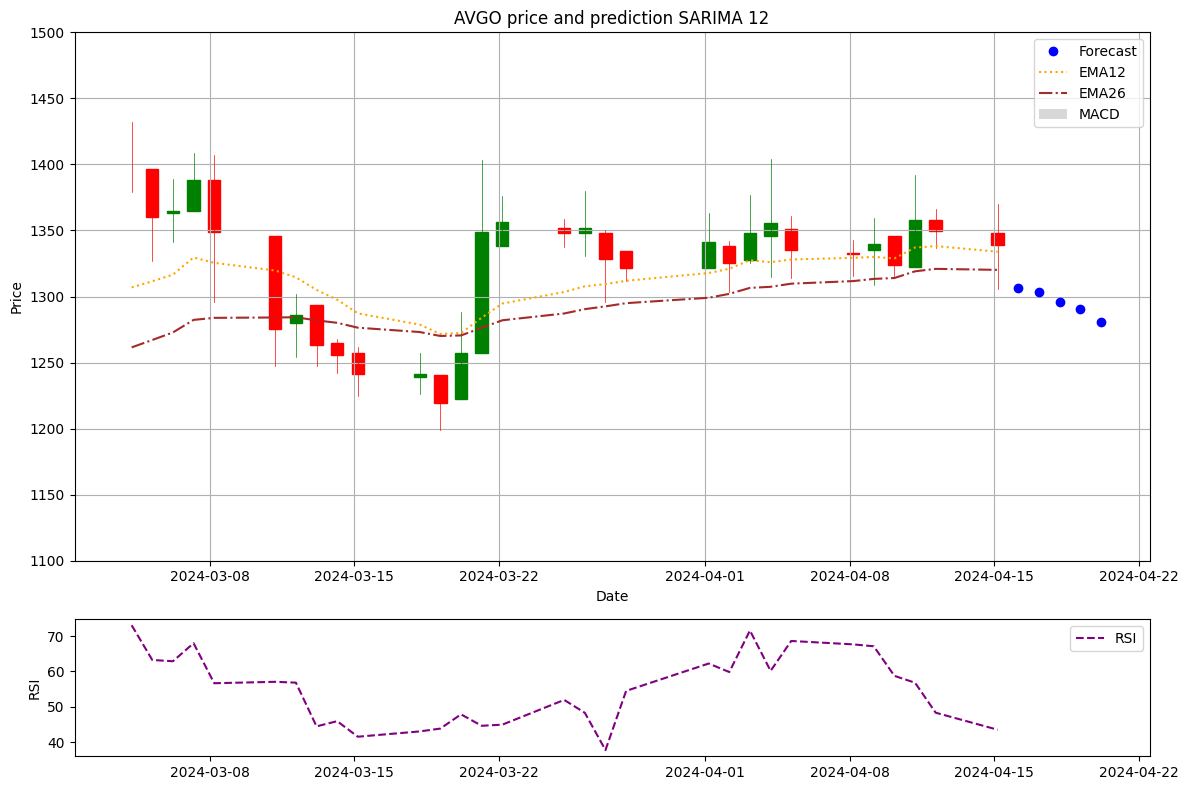

In [59]:
df_avgo_clean.index = pd.to_datetime(df_avgo_clean.index)

df_last_30 = df_avgo_clean.tail(30)

ha_close = (df_last_30['Open'] + df_last_30['High'] + df_last_30['Low'] + df_last_30['Close']) / 4
ha_open = (df_last_30['Open'].shift(1) + df_last_30['Close'].shift(1)) / 2
ha_high = df_last_30[['High', 'Open', 'Close']].max(axis=1)
ha_low = df_last_30[['Low', 'Open', 'Close']].min(axis=1)


df_ha = pd.DataFrame({'Date': df_last_30.index,
                      'Open': ha_open,
                      'High': ha_high,
                      'Low': ha_low,
                      'Close': ha_close})

plt.figure(figsize=(12, 8))

ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax1.xaxis_date()
ax1.grid(True)
ax1.set_ylim(1100, 1500)

df_ha['Date'] = df_ha['Date'].apply(mdates.date2num)

candlestick_ohlc(ax1, df_ha.values, width=0.6, colorup='green', colordown='red', alpha=1)

plt.plot(forecast_dates_sarima_12, forecast_with_dates_sarima_12['Forecast'], marker='o', color='blue', linestyle='None', label='Forecast')

# plt.plot(df_last_30.index, df_last_30['rsi'].tail(30), label='RSI', color='purple', linestyle='dashed')
plt.plot(df_last_30.index, df_last_30['ema_12'].tail(30), label='EMA12', color='orange', linestyle='dotted')
plt.plot(df_last_30.index, df_last_30['ema_26'].tail(30), label='EMA26', color='brown', linestyle='dashdot')
plt.bar(df_last_30.index, df_last_30['macd_line'].tail(30), label='MACD', color='gray', alpha=0.3)

plt.title('AVGO price and prediction SARIMA 12')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

ax2 = plt.subplot2grid((4, 1), (3, 0), sharex=ax3, rowspan=1)
ax2.bar(df_last_30.index, df_last_30['Volume'].tail(30), color='blue', alpha=0.5)
ax2.grid(True)
plt.ylabel('Volume') 

ax3 = plt.subplot2grid((4, 1), (3, 0), sharex=ax1, rowspan=1)

ax3.plot(df_last_30.index, df_last_30['rsi'].tail(30), label='RSI', color='purple', linestyle='dashed')

ax3.legend()
ax3.set_ylabel('RSI')
plt.tight_layout()

plt.show()

# SARIMA 4

In [27]:
s = 4
model_sarima_4 = auto_arima(df_close, seasonal=True, m=s, max_order=None)
model_sarima_4

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 4),
      suppress_warnings=True)

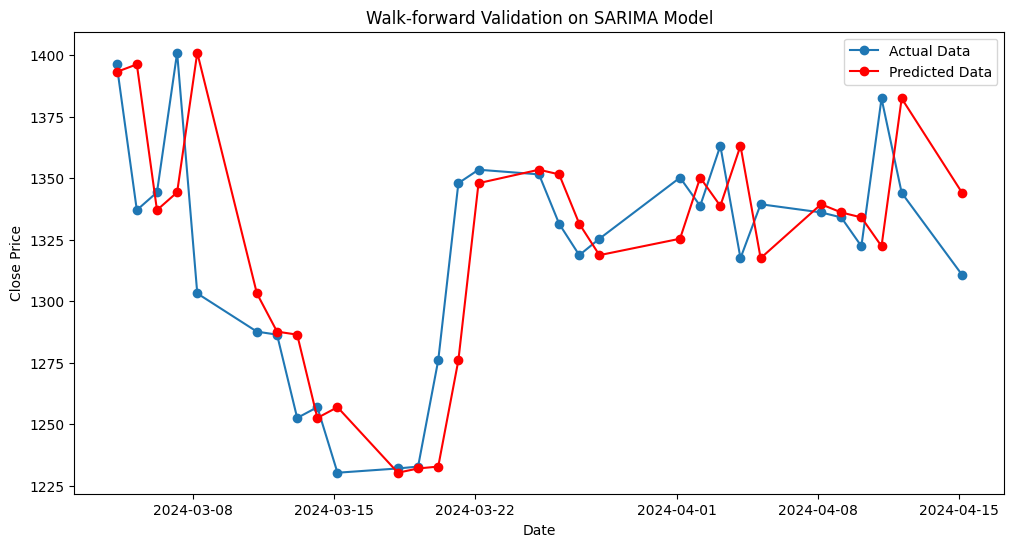

MSE: 1215.5066063199054


In [28]:
df_avgo_clean.index = pd.to_datetime(df_avgo_clean.index)
df_avgo_clean = df_avgo_clean.sort_index()

n_test = 30
train_data = df_avgo_clean['Close'].iloc[:-n_test]
test_data = df_avgo_clean['Close'].iloc[-n_test:]
dates = df_avgo_clean.index[-n_test:] 

history = train_data.copy()
predictions = []
for t in range(n_test):
    model = SARIMAX(history, order=(0, 1, 0), seasonal_order=(0, 0, 0, 12))
    model_fit = model.fit(disp=False)
    output = model_fit.forecast()
    yhat = output.iloc[0]
    predictions.append(yhat)
    obs = test_data.iloc[t]

    new_index = [dates[t]]
    history = pd.concat([history, pd.Series([obs], index=new_index)])

plt.figure(figsize=(12, 6))
plt.plot(dates, test_data, label='Actual Data', marker='o')
plt.plot(dates, predictions, color='red', label='Predicted Data', marker='o')
plt.legend()
plt.title("Walk-forward Validation on SARIMA Model")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

mse = mean_squared_error(test_data, predictions)
print('MSE:', mse)

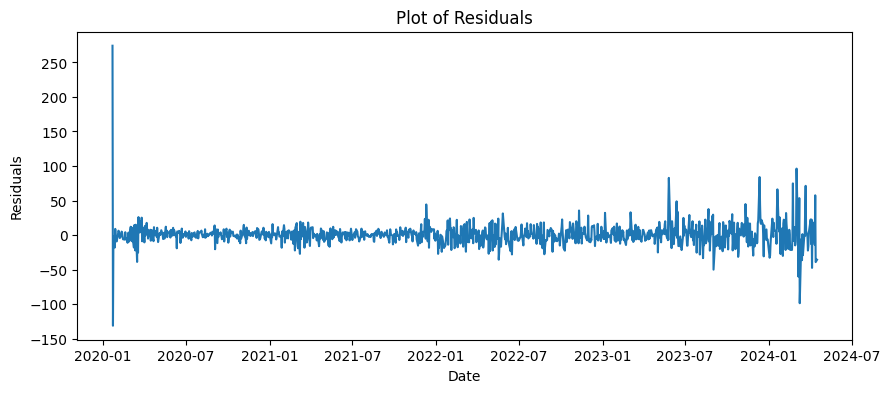

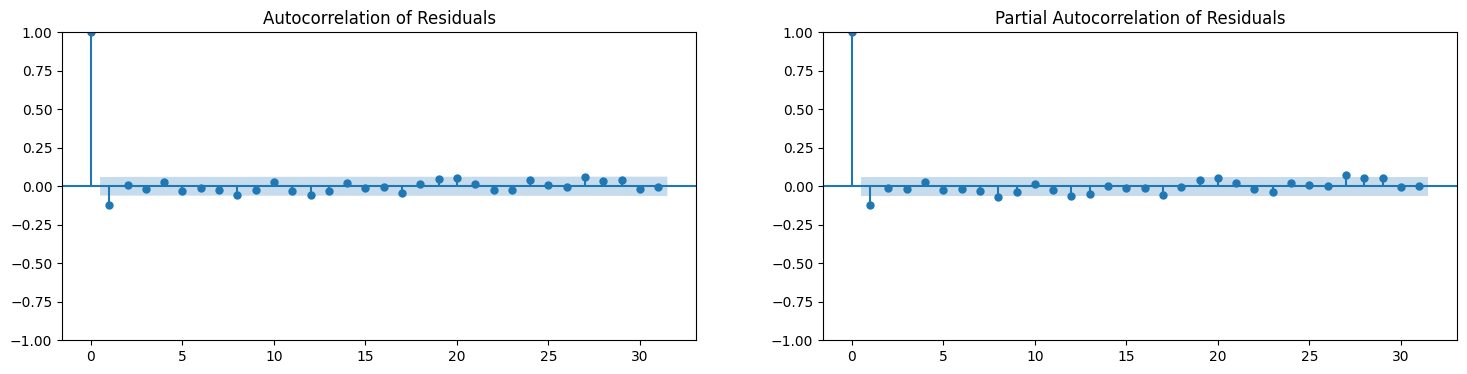

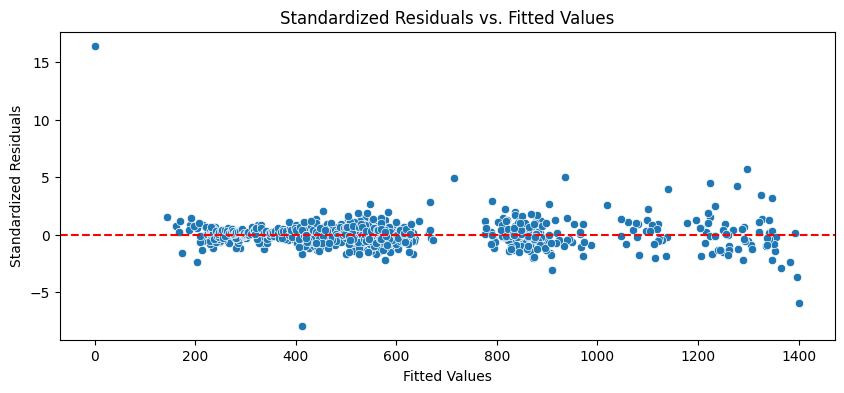

Forecasted values: [1314.4381013699813, 1316.9649249545455, 1318.8617486785613, 1320.7997167520446, 1322.747752603955]


In [31]:
order = (2, 2, 1)
seasonal_order = (0, 0, 0, 12)
model_sarimax_4 = SARIMAX(df_avgo_clean['Close'], order=order, seasonal_order=seasonal_order)
model_fit_sarima_4 = model_sarimax_4.fit()

residuals = model_fit_sarima_4.resid

# Plot of residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Plot of Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# ACF and PACF of residuals
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
plot_acf(residuals, ax=ax[0], title='Autocorrelation of Residuals')
plot_pacf(residuals, ax=ax[1], title='Partial Autocorrelation of Residuals')
plt.show()

# Standardized residuals vs. fitted values
fitted_values = model_fit_sarima_12.fittedvalues
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

plt.figure(figsize=(10, 4))
sns.scatterplot(x=fitted_values, y=standardized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Standardized Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Standardized Residuals')
plt.show()

forecast_sarima_4 = model_fit_sarima_4.forecast(steps=5)
forecast_values_sarima_4 = forecast_sarima_4.tolist()
print("Forecasted values:", forecast_values_sarima_4)

In [61]:
forecast_result = model_fit_sarima_4.get_forecast(steps=5)

mean_forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

forecast_df_sarima_4 = pd.DataFrame({
    'Forecast': mean_forecast,
    'Lower_95%': conf_int.iloc[:, 0],
    'Upper_95%': conf_int.iloc[:, 1]
})
forecast_df_sarima_4.index = pd.date_range(start=df_avgo_clean.index[-1], periods=6, freq=df_avgo_clean.index.freq)[1:]
forecast_df_sarima_4

,Forecast,Lower_95%,Upper_95%
2024-04-16 04:00:00,1314.438101,1287.382316,1341.493887
2024-04-17 04:00:00,1316.964925,1279.205264,1354.724586
2024-04-18 04:00:00,1318.861749,1273.025801,1364.697696
2024-04-19 04:00:00,1320.799717,1268.046030,1373.553404
2024-04-20 04:00:00,1322.747753,1263.834603,1381.660902


C:\Users\gijsv\AppData\Local\Temp\ipykernel_13776\3715270211.py:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)


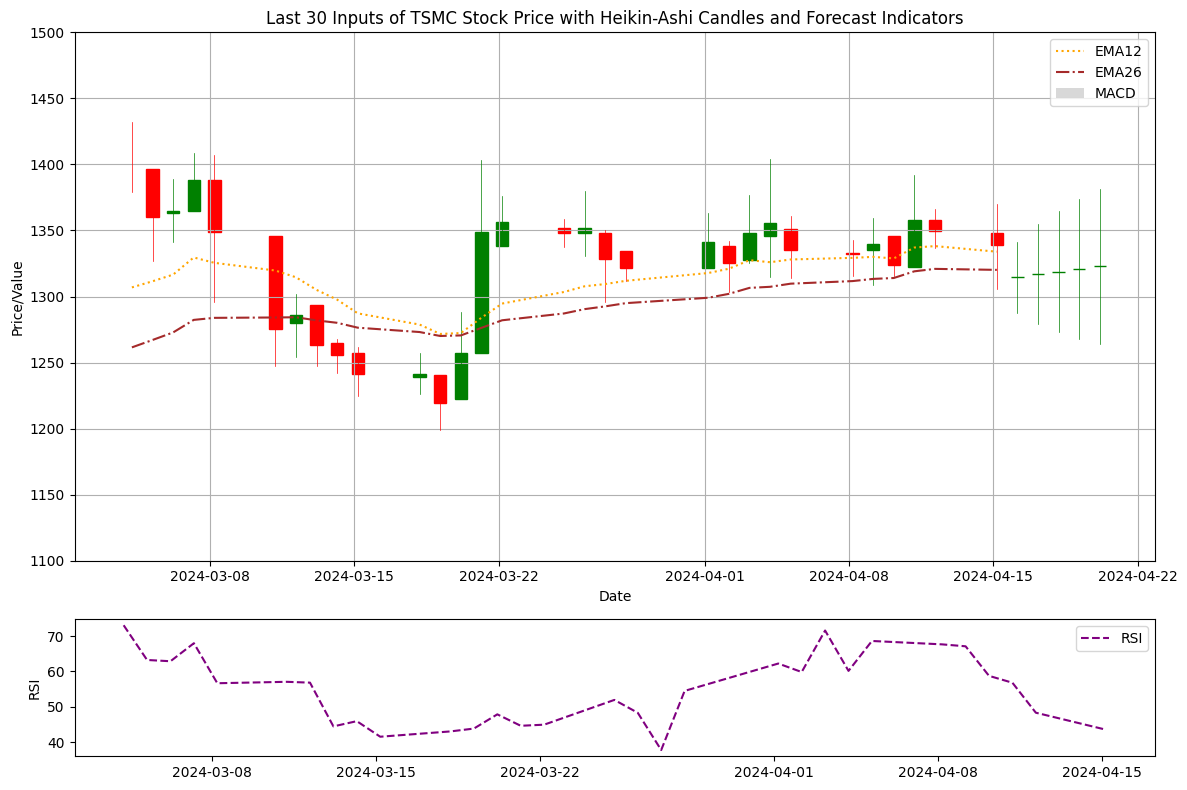

In [63]:
forecast_df_sarima_4['Date'] = forecast_df_sarima_4.index
forecast_df_sarima_4['Date'] = forecast_df_sarima_4['Date'].apply(mdates.date2num)

forecast_candles = pd.DataFrame({
    'Date': forecast_df_sarima_4['Date'],
    'Open': forecast_df_sarima_4['Forecast'],
    'High': forecast_df_sarima_4['Upper_95%'],
    'Low': forecast_df_sarima_4['Lower_95%'],
    'Close': forecast_df_sarima_4['Forecast']
})

full_candles = pd.concat([df_ha, forecast_candles])

plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax1.xaxis_date()
ax1.grid(True)
ax1.set_ylim(1100, 1500) 

candlestick_ohlc(ax1, full_candles.values, width=0.6, colorup='green', colordown='red', alpha=1)

plt.plot(df_last_30.index, df_last_30['ema_12'].tail(30), label='EMA12', color='orange', linestyle='dotted')
plt.plot(df_last_30.index, df_last_30['ema_26'].tail(30), label='EMA26', color='brown', linestyle='dashdot')
plt.bar(df_last_30.index, df_last_30['macd_line'].tail(30), label='MACD', color='gray', alpha=0.3)

plt.title('Last 30 Inputs of TSMC Stock Price with Heikin-Ashi Candles and Forecast Indicators')
plt.xlabel('Date')
plt.ylabel('Price/Value')
plt.legend()

ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
ax2.bar(df_last_30.index, df_last_30['Volume'].tail(30), color='blue', alpha=0.5)
ax2.grid(True)
plt.ylabel('Volume') 

ax3 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
ax3.plot(df_last_30.index, df_last_30['rsi'].tail(30), label='RSI', color='purple', linestyle='dashed')
ax3.legend()
ax3.set_ylabel('RSI')

plt.tight_layout()
plt.show()

In [32]:
last_date = df_avgo_clean.index[-1]

forecast_dates_sarima_4 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=5, freq='D')

forecast_with_dates_sarima_4 = pd.DataFrame({'Forecast': forecast_values_sarima_4}, index=forecast_dates_sarima_4)
print(forecast_with_dates_sarima_4)

                        Forecast
2024-04-16 04:00:00  1314.438101
2024-04-17 04:00:00  1316.964925
2024-04-18 04:00:00  1318.861749
2024-04-19 04:00:00  1320.799717
2024-04-20 04:00:00  1322.747753


C:\Users\gijsv\AppData\Local\Temp\ipykernel_13776\3064647268.py:45: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((4, 1), (3, 0), sharex=ax1, rowspan=1)


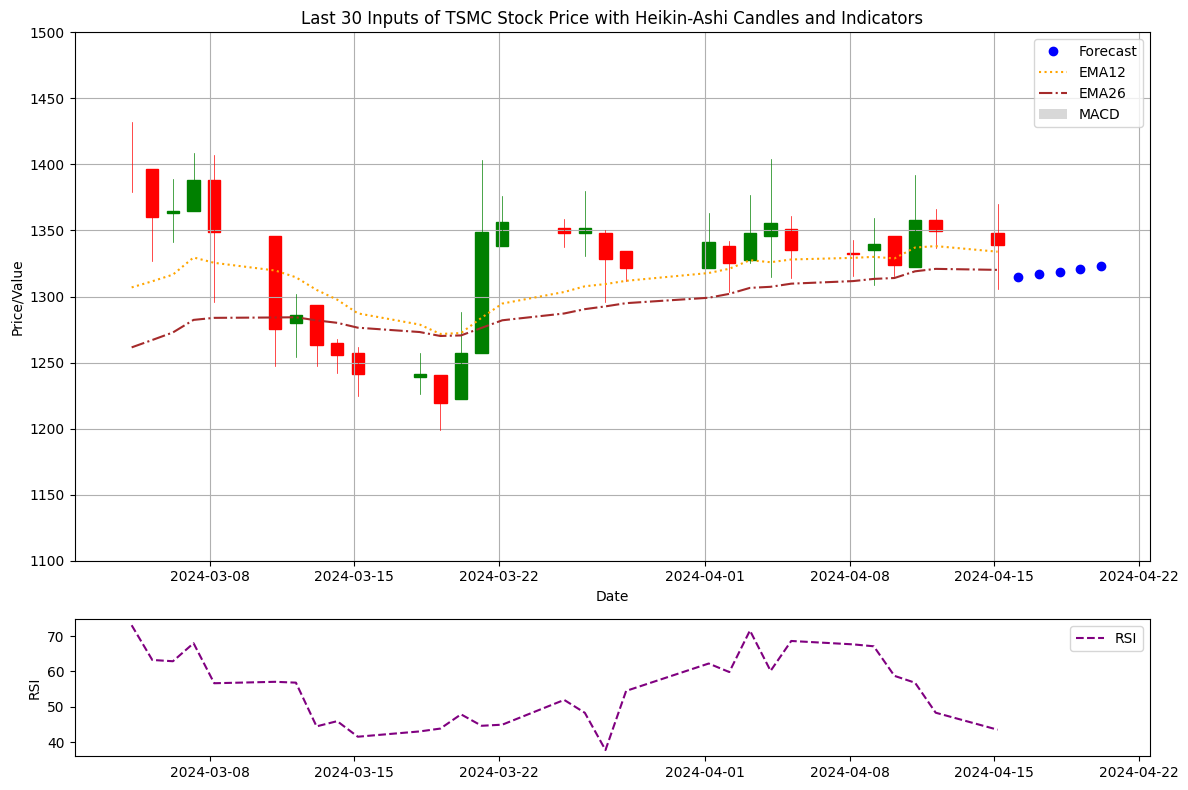

In [34]:
df_avgo_clean.index = pd.to_datetime(df_avgo_clean.index)

df_last_30 = df_avgo_clean.tail(30)

ha_close = (df_last_30['Open'] + df_last_30['High'] + df_last_30['Low'] + df_last_30['Close']) / 4
ha_open = (df_last_30['Open'].shift(1) + df_last_30['Close'].shift(1)) / 2
ha_high = df_last_30[['High', 'Open', 'Close']].max(axis=1)
ha_low = df_last_30[['Low', 'Open', 'Close']].min(axis=1)


df_ha = pd.DataFrame({'Date': df_last_30.index,
                      'Open': ha_open,
                      'High': ha_high,
                      'Low': ha_low,
                      'Close': ha_close})

plt.figure(figsize=(12, 8))

ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax1.xaxis_date()
ax1.grid(True)
ax1.set_ylim(1100, 1500)

df_ha['Date'] = df_ha['Date'].apply(mdates.date2num)

candlestick_ohlc(ax1, df_ha.values, width=0.6, colorup='green', colordown='red', alpha=1)

plt.plot(forecast_dates_sarima_4, forecast_with_dates_sarima_4['Forecast'], marker='o', color='blue', linestyle='None', label='Forecast')

# plt.plot(df_last_30.index, df_last_30['rsi'].tail(30), label='RSI', color='purple', linestyle='dashed')
plt.plot(df_last_30.index, df_last_30['ema_12'].tail(30), label='EMA12', color='orange', linestyle='dotted')
plt.plot(df_last_30.index, df_last_30['ema_26'].tail(30), label='EMA26', color='brown', linestyle='dashdot')
plt.bar(df_last_30.index, df_last_30['macd_line'].tail(30), label='MACD', color='gray', alpha=0.3)

plt.title('Last 30 Inputs of TSMC Stock Price with Heikin-Ashi Candles and Indicators')
plt.xlabel('Date')
plt.ylabel('Price/Value')
plt.legend()

ax2 = plt.subplot2grid((4, 1), (3, 0), sharex=ax3, rowspan=1)
ax2.bar(df_last_30.index, df_last_30['Volume'].tail(30), color='blue', alpha=0.5)
ax2.grid(True)
plt.ylabel('Volume') 

ax3 = plt.subplot2grid((4, 1), (3, 0), sharex=ax1, rowspan=1)

ax3.plot(df_last_30.index, df_last_30['rsi'].tail(30), label='RSI', color='purple', linestyle='dashed')

ax3.legend()
ax3.set_ylabel('RSI')
plt.tight_layout()

plt.show()